In [1]:
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

import copy

from torchsummary import summary

import matplotlib.pyplot as plt

# Data import and cleaning

In [2]:
emnist_data = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
print(emnist_data.classes)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
print(str(len(emnist_data.classes))+'classes')

27classes


In [6]:
print(emnist_data.data.shape)

torch.Size([124800, 28, 28])


In [7]:
images=emnist_data.data.view(124800,1,28,28) #color channel = 1 == greyscale
print(images.shape)

torch.Size([124800, 1, 28, 28])


In [8]:
print(torch.sum(emnist_data.targets==0))

torch.unique(emnist_data.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [9]:
# there is no data for class '0' or N/A

#removing the first class category
letter_cat = emnist_data.classes[1:]

#relabling
labels = copy.deepcopy(emnist_data.targets)-1
print(labels.unique())
print(labels.shape)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])
torch.Size([124800])


In [10]:
print(torch.sum(labels==0)) # actually standing for label 'a' now

tensor(4800)


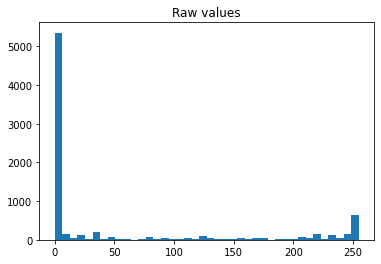

In [11]:
# Normalizing the images
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('Raw values');



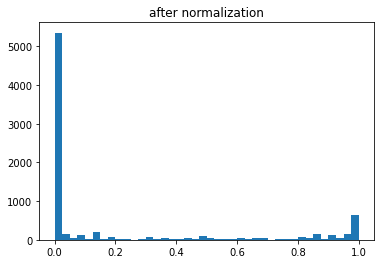

In [12]:
images = images/torch.max(images)
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('after normalization')
plt.show()

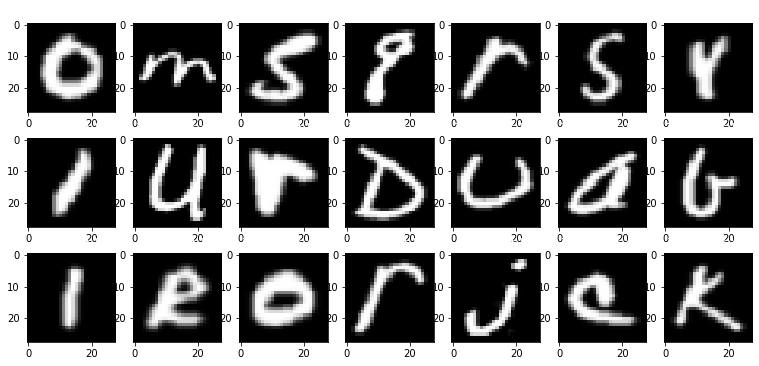

In [13]:
# Visuzalizing some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

    #picking pictures
    which_pic = np.random.randint(images.shape[0])

    #extract the images and it's target letter
    I = np.squeeze(images[which_pic,:,:,:])
    letter = letter_cat[labels[which_pic]]

    #visialize
    ax.imshow(I.T,cmap='gray')
    ax.set_title('The letter "%s"'%letter,c='w')

plt.show();


# Prepare data for network

In [14]:
# step 2: use sklearn to get train test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.5)

#step 3: get tensor dataset
train_data = TensorDataset(X_train,y_train)
test_data = TensorDataset(X_test,y_test)

#step 4: Translate into torch dataloader object
batch_sz = 32
train_loader = DataLoader(train_data,batch_size=batch_sz,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [15]:
# Checkting the data loaders
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([62400, 1, 28, 28])
torch.Size([62400])


# Create the Dl model

In [28]:
out_chan_l1= None   #layer 1 output
out_chan_l2=None
out_chan_l3=None


# create a class for the model
def make_net(printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,64,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(64,128,3)
      self.bnorm2 = nn.BatchNorm2d(128) # input the number of channels in this layer
      # output size: (14+2*0-3)/1 + 1 = 12/2 = 6 (/2 b/c maxpool)

      # third convolution layer
      self.conv3  = nn.Conv2d(128,256,3)
      self.bnorm3 = nn.BatchNorm2d(256) # input the number of channels in this layer
      # output size: (6+2*0-3)/1 + 1 = 4/2 = 2 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(2*2*256,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64,26)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x,p=.25,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x,p=.25,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x,p=.25,training=self.training)
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      print( 'x.shape.numel()',x.shape.numel())
      print('n_units: ',nUnits)
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = emnistnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [29]:
# test the model with one batch
net,lossfun,optimizer = make_net()

X,y = iter(train_loader).next()
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

x.shape.numel() 768
n_units:  96.0

Output size:
torch.Size([8, 26])
 
Loss:
tensor(3.2734, grad_fn=<NllLossBackward0>)


In [30]:
X,y =next(iter( test_loader))
X.shape

torch.Size([62400, 1, 28, 28])

In [31]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = make_net()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)

    # test performance
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    net.eval()
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

In [32]:
print(summary(net,input_size=(1, 28, 28),device='cpu'))

x.shape.numel() 192
n_units:  96.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 14, 14]               8
            Conv2d-3           [-1, 12, 12, 12]             444
       BatchNorm2d-4             [-1, 12, 6, 6]              24
            Conv2d-5             [-1, 24, 4, 4]           2,616
       BatchNorm2d-6             [-1, 24, 2, 2]              48
            Linear-7                  [-1, 256]          24,832
            Linear-8                   [-1, 64]          16,448
            Linear-9                   [-1, 26]           1,690
Total params: 46,150
Trainable params: 46,150
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.18
Estimated Total Size (MB): 0.23
----------

In [33]:
# ~4 minutes with 10 epochs on GPU
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel()

x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768
n_units:  96.0
x.shape.numel() 768


RuntimeError: CUDA out of memory. Tried to allocate 374.00 MiB (GPU 0; 2.00 GiB total capacity; 1.28 GiB already allocated; 0 bytes free; 1.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(5,6))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.tight_layout()
plt.show()